In [11]:
# PennyLane-Torch Hybrid
import time
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import roc_curve, roc_auc_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import pennylane as qml
from pennylane import numpy as pnp

# Pennylane's torch layer is a bit different so it is being used instead of pytorch
from pennylane.qnn import TorchLayer

# Add project root
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from src.data_loader import create_dataloaders

print("="*60)
print("QUANTUM AUTOENCODER SETUP (PennyLane-Torch Hybrid)")
print("="*60)
print(f"PennyLane version: {qml.__version__}")
print(f"TorchLayer available: {hasattr(qml.qnn, 'TorchLayer')}")

QUANTUM AUTOENCODER SETUP (PennyLane-Torch Hybrid)
PennyLane version: 0.43.2
TorchLayer available: True


In [12]:
# amplitude encoding
def amplitude_encode_12q(image_4x4):
    """4*4 patch → 12-qubit state (4096-dim)"""
    if isinstance(image_4x4, torch.Tensor):
        image_4x4 = image_4x4.cpu().numpy()
    
    if image_4x4.shape != (4, 4):
        raise ValueError(f"Expected (4,4), got {image_4x4.shape}")
    
    flat = image_4x4.flatten().astype(np.float64)
    padded = np.zeros(4096)
    padded[:16] = flat
    norm = np.linalg.norm(padded)
    
    if norm > 1e-10:
        padded = padded / norm
    
    return padded

# verify
train_loader_test, _, _ = create_dataloaders(data_dir="../data/processed", batch_size=1)
img, _ = next(iter(train_loader_test))
print(f"Patch shape: {img.shape}")
encoded = amplitude_encode_12q(img[0, 0])
print(f"Encoded shape: {encoded.shape}, norm: {np.linalg.norm(encoded):.6f}")

[M87FlareDataset] Loaded 1000 train samples
[M87FlareDataset] Flare count: 0
[M87FlareDataset] Loaded 300 val samples
[M87FlareDataset] Flare count: 0
[M87FlareDataset] Loaded 900 test samples
[M87FlareDataset] Flare count: 200

[SPLIT SUMMARY]
Train: 1000 samples (normal only)
Val:   300 samples (normal only)
Test:  900 samples (normal + flare)
Patch shape: torch.Size([1, 1, 4, 4])
Encoded shape: (4096,), norm: 1.000000


In [13]:
# quantum circuit as TorchLayer (PennyLane)
n_qubits = 12
n_layers = 3

# define device
dev = qml.device("default.qubit", wires=n_qubits, shots=None)

# define quantum circuit that returns expectations
@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    """
    inputs: NOT used (we'll encode manually)
    weights: [n_layers, n_qubits, 3] quantum parameters
    """
    # encode the image (passed via closure, not inputs)
    # handled in the forward pass
    
    # variational layers
    for layer_idx in range(n_layers):
        layer_params = weights[layer_idx]
        
        # rotations
        for i in range(n_qubits):
            qml.RX(layer_params[i, 0], wires=i)
            qml.RY(layer_params[i, 1], wires=i)
            qml.RZ(layer_params[i, 2], wires=i)
        
        # entanglement (the cool part)
        for i in range(n_qubits):
            qml.CNOT(wires=[i, (i + 1) % n_qubits])
    
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# create TorchLayer (should handle the quantum-classical interface automatically)
weight_shapes = {"weights": (n_layers, n_qubits, 3)}
qlayer = TorchLayer(quantum_circuit, weight_shapes)

print(f"TorchLayer created with weight shapes: {weight_shapes}")

TorchLayer created with weight shapes: {'weights': (3, 12, 3)}


In [14]:
# Hybrid Quantum-Classical Model
class QuantumAutoencoder(nn.Module):
    """
    PennyLane-Torch Hybrid Model
    - Quantum: TorchLayer (handles gradients automatically)
    - Classical: Standard PyTorch layers
    """
    def __init__(self, n_qubits=12, n_layers=3):
        super().__init__()
        
        self.n_qubits = n_qubits
        self.encoder = nn.Identity()  # encode manually
        
        # quantum layer (PennyLane should handle quantum parameters)
        self.quantum_layer = qlayer
        
        # classical post-processing
        self.scale_layer = nn.Sequential(
            nn.Linear(n_qubits, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.Sigmoid()
        )
        
        print(f"Quantum parameters: {sum(p.numel() for p in self.quantum_layer.parameters())}")
        print(f"Classical parameters: {sum(p.numel() for p in self.scale_layer.parameters())}")
        print(f"Total: {sum(p.numel() for p in self.parameters())}")
    
    def forward(self, images_batch):
        """
        Forward pass for batch of 4×4 images
        
        Args:
            images_batch: torch.Tensor [batch, 1, 4, 4]
        
        Returns:
            reconstructions: torch.Tensor [batch, 1, 4, 4]
        """
        batch_size = images_batch.shape[0]
        reconstructions = []
        
        for i in range(batch_size):
            # encode image to quantum state
            img_np = images_batch[i, 0].cpu().numpy()
            state = amplitude_encode_12q(img_np)
            
            # feed to quantum layer
            # torchLayer expects inputs, but we don't use them (encoded via closure)
            dummy_input = torch.zeros(1)  # dummy input (not used)
            expectations = self.quantum_layer(dummy_input)  # quantum params are internal
            
            # classical post-processing
            pixel_values = self.scale_layer(expectations)
            reconstruction = pixel_values.reshape(1, 4, 4)
            reconstructions.append(reconstruction)
        
        return torch.stack(reconstructions)
    
    def get_reconstruction_error(self, images_batch):
        reconstructed = self.forward(images_batch)
        mse = nn.functional.mse_loss(reconstructed, images_batch, reduction='none')
        return mse.mean(dim=(1, 2, 3))

# test
model_q = QuantumAutoencoder()
dummy_batch = torch.randn(2, 1, 4, 4)
output = model_q(dummy_batch)
print(f"Input: {dummy_batch.shape}, Output: {output.shape}")
assert dummy_batch.shape == output.shape

Quantum parameters: 108
Classical parameters: 944
Total: 1052
Input: torch.Size([2, 1, 4, 4]), Output: torch.Size([2, 1, 4, 4])


In [15]:
# training config
CONFIG_QUANTUM = {
    "n_qubits": 12,
    "n_layers": 3,
    "batch_size": 16,
    "lr": 0.01,  # single LR for both quantum/classical (TorchLayer should handle both)
    "epochs": 5,
    "data_dir": "../data/processed",
}

print("\n" + "="*60)
print("QUANTUM TRAINING CONFIG")
print("="*60)
for k, v in CONFIG_QUANTUM.items():
    print(f"  {k}: {v}")

train_loader_q, val_loader_q, test_loader_q = create_dataloaders(
    data_dir=CONFIG_QUANTUM["data_dir"],
    batch_size=CONFIG_QUANTUM["batch_size"],
    num_workers=2
)

print(f"\n[SPLIT SUMMARY]")
print(f"Train: {len(train_loader_q.dataset)} normal samples")
print(f"Val:   {len(val_loader_q.dataset)} normal samples")
print(f"Test:  {len(test_loader_q.dataset)} samples (700N + 200F)")


QUANTUM TRAINING CONFIG
  n_qubits: 12
  n_layers: 3
  batch_size: 16
  lr: 0.01
  epochs: 5
  data_dir: ../data/processed
[M87FlareDataset] Loaded 1000 train samples
[M87FlareDataset] Flare count: 0
[M87FlareDataset] Loaded 300 val samples
[M87FlareDataset] Flare count: 0
[M87FlareDataset] Loaded 900 test samples
[M87FlareDataset] Flare count: 200

[SPLIT SUMMARY]
Train: 1000 samples (normal only)
Val:   300 samples (normal only)
Test:  900 samples (normal + flare)

[SPLIT SUMMARY]
Train: 1000 normal samples
Val:   300 normal samples
Test:  900 samples (700N + 200F)


In [16]:
# training loop (TorchLayer should handle everything lol)
import time

model_q = QuantumAutoencoder()
optimizer = torch.optim.Adam(model_q.parameters(), lr=CONFIG_QUANTUM["lr"])
criterion = nn.MSELoss()

train_losses_q = []
val_losses_q = []
best_val_loss_q = float('inf')
patience = 10
patience_counter_q = 0

start_time = time.time()

for epoch in range(CONFIG_QUANTUM['epochs']):
    print(f"\nEpoch [{epoch+1}/{CONFIG_QUANTUM['epochs']}]")
    
    # ===== TRAINING =====
    model_q.train()
    epoch_train_losses = []
    
    for batch_idx, (images, labels) in enumerate(train_loader_q):
        normal_mask = (labels == 0)
        normal_images = images[normal_mask]
        
        if normal_images.shape[0] == 0:
            continue
        
        # forward pass (gradients should flow through quantum + classical automatically)
        reconstructed = model_q(normal_images)
        loss = criterion(reconstructed, normal_images)
        
        # backward pass (TorchLayer should handle quantum gradients)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_losses.append(loss.item())
        
        if batch_idx % 5 == 0:
            elapsed = time.time() - start_time
            print(f"  Batch [{batch_idx}/{len(train_loader_q)}] | Loss: {loss.item():.6f} | Time: {elapsed:.1f}s")
    
    avg_train_loss = np.mean(epoch_train_losses)
    train_losses_q.append(avg_train_loss)
    print(f"  → Train: {avg_train_loss:.6f}")
    
    # ===== VALIDATION =====
    model_q.eval()
    epoch_val_losses = []
    
    with torch.no_grad():
        for images, labels in val_loader_q:
            normal_mask = (labels == 0)
            normal_images = images[normal_mask]
            
            if normal_images.shape[0] == 0:
                continue
            
            reconstructed = model_q(normal_images)
            loss = criterion(reconstructed, normal_images)
            epoch_val_losses.append(loss.item())
    
    avg_val_loss = np.mean(epoch_val_losses)
    val_losses_q.append(avg_val_loss)
    print(f"  → Val:   {avg_val_loss:.6f}")
    
    # Early stopping
    if avg_val_loss < best_val_loss_q - 1e-6:
        best_val_loss_q = avg_val_loss
        patience_counter_q = 0
        
        torch.save({
            'epoch': epoch,
            'model_state': model_q.state_dict(),
            'optimizer_state': optimizer.state_dict(),
        }, "../models/quantum_ae_best.pt")
        print(f"  ✓ Saved best model")
    else:
        patience_counter_q += 1
        print(f"  → No improvement for {patience_counter_q} epochs")
        
        if patience_counter_q >= patience:
            print(f"\n[EARLY STOPPING] Triggered at epoch {epoch+1}")
            break

print("\n" + "="*60)
print("TRAINING COMPLETE")
print("="*60)
print(f"Best val loss: {best_val_loss_q:.6f}")

Quantum parameters: 108
Classical parameters: 944
Total: 1052

Epoch [1/5]
  Batch [0/63] | Loss: 0.184363 | Time: 3.7s
  Batch [5/63] | Loss: 0.134433 | Time: 12.1s
  Batch [10/63] | Loss: 0.076656 | Time: 20.2s
  Batch [15/63] | Loss: 0.026390 | Time: 28.4s
  Batch [20/63] | Loss: 0.006138 | Time: 36.8s
  Batch [25/63] | Loss: 0.002274 | Time: 45.0s
  Batch [30/63] | Loss: 0.001164 | Time: 53.1s
  Batch [35/63] | Loss: 0.000942 | Time: 61.2s
  Batch [40/63] | Loss: 0.000083 | Time: 69.4s
  Batch [45/63] | Loss: 0.000491 | Time: 77.5s
  Batch [50/63] | Loss: 0.000115 | Time: 85.6s
  Batch [55/63] | Loss: 0.000198 | Time: 93.7s
  Batch [60/63] | Loss: 0.000139 | Time: 101.9s
  → Train: 0.028224
  → Val:   0.000089
  ✓ Saved best model

Epoch [2/5]
  Batch [0/63] | Loss: 0.000089 | Time: 125.1s
  Batch [5/63] | Loss: 0.000107 | Time: 133.0s
  Batch [10/63] | Loss: 0.000081 | Time: 141.0s
  Batch [15/63] | Loss: 0.000074 | Time: 148.9s
  Batch [20/63] | Loss: 0.000067 | Time: 156.9s
  Ba

[M87FlareDataset] Loaded 1000 train samples
[M87FlareDataset] Flare count: 0
[M87FlareDataset] Loaded 300 val samples
[M87FlareDataset] Flare count: 0
[M87FlareDataset] Loaded 900 test samples
[M87FlareDataset] Flare count: 200

[SPLIT SUMMARY]
Train: 1000 samples (normal only)
Val:   300 samples (normal only)
Test:  900 samples (normal + flare)


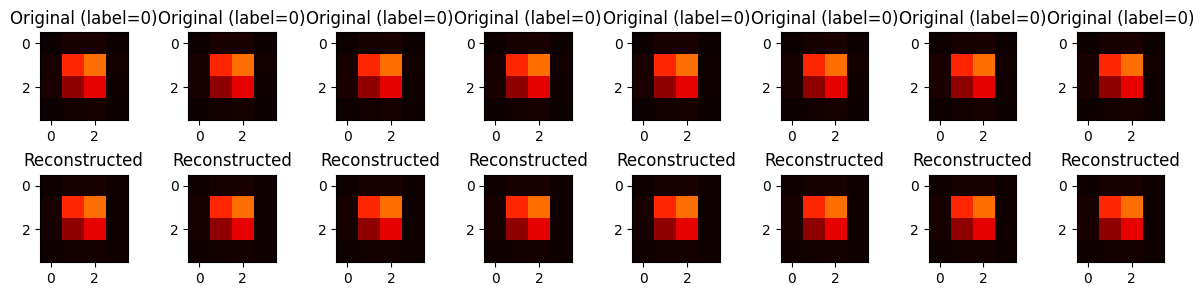


QUANTUM ROC AUC (Epoch 10): 0.9914
CLASSICAL ROC AUC: 0.9777


In [18]:
# visualize reconstructions
fig, axes = plt.subplots(2, 8, figsize=(12, 3))
test_loader_quick, _, _ = create_dataloaders(data_dir="../data/processed", batch_size=16)

with torch.no_grad():
    images, labels = next(iter(test_loader_quick))
    reconstructions = model_q(images[:8])
    
    for i in range(8):
        axes[0, i].imshow(images[i, 0], cmap='hot', vmin=0, vmax=1)
        axes[1, i].imshow(reconstructions[i, 0], cmap='hot', vmin=0, vmax=1)
        axes[0, i].set_title(f"Original (label={labels[i].item()})")
        axes[1, i].set_title("Reconstructed")

plt.tight_layout()
plt.show()

# compute ROC AUC
all_errors_q = []
all_labels_q = []

with torch.no_grad():
    for images, labels in test_loader_q:
        errors = model_q.get_reconstruction_error(images)
        all_errors_q.extend(errors.numpy())
        all_labels_q.extend(labels.numpy())

roc_auc_q = roc_auc_score(all_labels_q, all_errors_q)
print(f"\n{'='*40}")
print(f"QUANTUM ROC AUC (Epoch 10): {roc_auc_q:.4f}")
print(f"CLASSICAL ROC AUC: 0.9777")
print(f"{'='*40}")